In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import main, draw
import numpy as np
from explearner import *
from explearner import datasets as data

from sklearn.utils import check_random_state
from itertools import product
from os.path import join

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
DATASETS = {
    # Datasets with ground-truth explanations
    'debug':
        data.DebugDataset,
    'line':
        data.LineDataset,
    'sine':
        data.SineDataset,
    'colors-0-relevance':
        lambda *args, **kwargs:
            data.ColorsDataset(*args, rule=0, kind='relevance', **kwargs),
    'colors-1-relevance':
        lambda *args, **kwargs:
            data.ColorsDataset(*args, rule=1, kind='relevance', **kwargs),
    'colors-0-polarity':
        lambda *args, **kwargs:
            data.ColorsDataset(*args, rule=0, kind='polarity', **kwargs),
    'colors-1-polarity':
        lambda *args, **kwargs:
            data.ColorsDataset(*args, rule=1, kind='polarity', **kwargs),

    # Datasets with explanations extracted from a model
    'banknote':
        data.BanknoteAuth,
    'breast':
        data.BreastCancer,
    'wine':
        data.WineQuality,
}

class Arguments: 
    def __init__(self, dataset, combiner, strategy, n_splits, n_iters, p_known = 0.01, noise = 0, seed = 0, passive = False): 
        self.dataset = dataset
        self.combiner = combiner
        self.noise = noise
        self.seed = seed
        self.strategy = strategy
        self.n_splits = n_splits
        self.p_known = p_known
        self.n_iters = n_iters
        self.passive = passive

def plot_dataset(traces, trace_args): 
    n_pickles, n_folds, n_iters, n_measures = traces.shape

    cumavg = lambda y: 1 / np.arange(1, len(y) + 1) * np.cumsum(y)
    PLOTS = [
        ('Regret', 0, None),
        ('Cum. Regret', 0, cumavg),
        ('Test Regret', 1, None),
    ]    

    for j, (y_label, index, transform) in enumerate(PLOTS):
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))

        ax.set_xlabel('Iterations')
        ax.set_ylabel(y_label)

        for p in range(n_pickles):
            perf = traces[p, :, :, index]

            x = np.arange(n_iters)
            y = np.mean(perf, axis=0)
            if transform:
                y = transform(y)
            yerr = np.std(perf, axis=0) / np.sqrt(n_folds)

            label, color, linestyle = draw.get_style(args, trace_args[p])
            ax.plot(x, y, linewidth=2,
                    label=label, color=color, linestyle=linestyle)
            ax.fill_between(x, y - yerr, y + yerr,
                            alpha=0.35, linewidth=0, color=color)

        ax.legend(loc='upper right', fontsize=8, shadow=False)
        fig.savefig(args.dataset + '__{}.png'.format(j),
                    bbox_inches='tight',
                    pad_inches=0)
        del fig

In [56]:
combiners = ['sum','prod']
strategies = ['random','ucb']
datasets = ['wine']
n_splits = 3 
n_iters = 100

from sklearn.gaussian_process.kernels import RationalQuadratic

kx = RBF(length_scale=1, length_scale_bounds=(0.1, 2.0))
# kz = DotProduct(sigma_0 = 1, sigma_0_bounds=(0,10))
kz = RBF(length_scale=1, length_scale_bounds=(0.1, 2.0))
ky = RBF(length_scale=1, length_scale_bounds=(0.1, 2.0))

# ky = DotProduct(sigma_0 = 0, sigma_0_bounds=(0,0))


In [60]:
for ds in datasets: 
    for combiner in combiners: 
        for strategy in strategies: 
            args = Arguments(ds, combiner, strategy, n_splits, n_iters) 

            np.set_printoptions(precision=3, linewidth=80)

            np.random.seed(args.seed) # XXX just in case
            rng = np.random.RandomState(args.seed)

            dataset = DATASETS[args.dataset](kx = kx, kz = kz, ky = ky, combiner=args.combiner, rng=rng) 
            
            traces = [main.evaluate_fold(dataset, tr, ts, args, rng=rng)
                    for tr, ts in list(dataset.split(args.n_splits))]

            path = main._get_basename(args) + '__trace.pickle'
            main.dump(join('results', path), {
                'args': args,
                'traces': traces
            })

best params: {'max_depth': 5, 'max_features': 'auto', 'random_state': 0}
-0.589 ± 0.135 for {'max_depth': 5, 'max_features': 'auto', 'random_state': 0}
-0.589 ± 0.135 for {'max_depth': 5, 'max_features': None, 'random_state': 0}
-0.783 ± 0.190 for {'max_depth': 10, 'max_features': 'auto', 'random_state': 0}
-0.783 ± 0.190 for {'max_depth': 10, 'max_features': None, 'random_state': 0}
-1.105 ± 0.226 for {'max_depth': None, 'max_features': 'auto', 'random_state': 0}
-1.105 ± 0.226 for {'max_depth': None, 'max_features': None, 'random_state': 0}
running fold:  #arms=210 - #kn=33 #tr=3265 #ts=20
iter: best reg=3.989 test reg=3.989  ctx 2090  true=([1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 5) pred=([1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 3)
iter: best reg=3.989 test reg=3.

/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=3.989 test reg=3.581  ctx 3123  true=([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 5) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1.], 6)
iter: best reg=3.989 test reg=3.581  ctx 21  true=([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0], 7) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1.], 6)


/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=2.660 test reg=3.714  ctx 512  true=([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0.], 6)
iter: best reg=3.989 test reg=3.714  ctx 4636  true=([1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 5) pred=([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)


/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=2.660 test reg=3.714  ctx 4029  true=([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1.], 6)
iter: best reg=3.192 test reg=3.732  ctx 2344  true=([1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)
iter: best reg=3.989 test reg=3.732  ctx 1027  true=([1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 4) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=3.989 test reg=3.714  ctx 1204  true=([1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0.], 7)
iter: best reg=3.627 test reg=3.714  ctx 3551  true=([1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)


/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=3.989 test reg=3.714  ctx 114  true=([1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 5) pred=([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)
iter: best reg=3.989 test reg=3.714  ctx 2496  true=([1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 5) pred=([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)


/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=3.989 test reg=3.714  ctx 293  true=([1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 7) pred=([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)
iter: best reg=1.995 test reg=3.714  ctx 4418  true=([1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)


/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=3.192 test reg=3.732  ctx 366  true=([1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)
iter: best reg=3.989 test reg=3.644  ctx 3100  true=([1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 7) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0.], 6)


/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=3.989 test reg=3.644  ctx 2095  true=([1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 5) pred=([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 6)


/Users/au611722/opt/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iter: best reg=3.192 test reg=3.644  ctx 2241  true=([1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 5) pred=([1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.], 5)
iter: best reg=3.989 test reg=3.559  ctx 1252  true=([1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0.], 7)
iter: best reg=2.660 test reg=3.559  ctx 3259  true=([1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 6) pred=([1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

KeyboardInterrupt: 

['./results/wine__C=sum__N=0__S=ucb__k=3__K=0.01__T=100__0__trace.pickle', './results/wine__C=prod__N=0__S=ucb__k=3__K=0.01__T=100__0__trace.pickle', './results/wine__C=prod__N=0__S=random__k=3__K=0.01__T=100__0__trace.pickle', './results/wine__C=sum__N=0__S=random__k=3__K=0.01__T=100__0__trace.pickle']
Dataset: wine


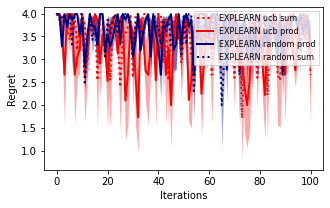

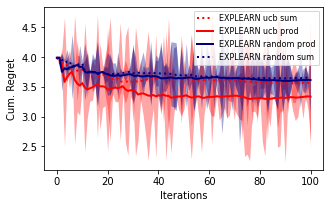

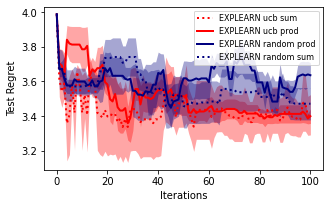

In [61]:
from os.path import join
import glob

results = './results/'

for ds in datasets: 
    pickles = glob.glob(join(results, f'{ds}*T={n_iters}*'))
    print(pickles)

    traces, trace_args = [], []
    for path in pickles:
        data = load(path)
        traces.append(data['traces'])
        trace_args.append(data['args'])
    traces = np.array(traces)

    print(f'=============\nDataset: {ds}\n=============')
    plot_dataset(traces, trace_args)
    